# 2. Feature Engineering and RFM Segmentation

### Project Objective
This notebook builds on the cleaned data from the previous step to perform a classic **Recency, Frequency, Monetary (RFM)** analysis. RFM is a powerful marketing technique used to segment customers based on their purchasing behavior.

### What is RFM?
- **Recency:** How recently did the customer make a purchase? (More recent = better)
- **Frequency:** How often do they purchase? (More frequent = better)
- **Monetary:** How much do they spend? (Higher spend = better)

By scoring customers on these three dimensions, we can create intuitive, actionable segments like "Champions," "Loyal Customers," and "At-Risk Customers."

### Objectives of this Notebook
1.  **Calculate RFM Metrics:** Engineer the Recency, Frequency, and Monetary values for each customer.
2.  **Create RFM Scores:** Convert the raw metrics into scores (typically 1-5) to allow for easy comparison.
3.  **Develop Business Segments:** Define and apply business rules based on the RFM scores to create named segments.
4.  **Analyze and Visualize Segments:** Profile each segment to understand its size, value, and characteristics, and present the findings in a business-friendly format.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Load pre-cleaned customer data
customer_data = pd.read_csv('../data/processed/clean_customer_data.csv')
customer_data['InvoiceDate'] = pd.to_datetime(customer_data['InvoiceDate'])

print(f"Loaded clean customer data: {len(customer_data):,} transactions")
print(f"Customers for RFM analysis: {customer_data['CustomerID'].nunique():,}")

# Set analysis date (day after last transaction for recency calculation)
analysis_date = customer_data['InvoiceDate'].max() + timedelta(days=1)
print(f"Analysis date set to: {analysis_date}")

# Calculate RFM metrics
rfm_data = customer_data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (analysis_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency  
    'Revenue': 'sum'                                         # Monetary
}).round(2)

rfm_data.columns = ['Recency', 'Frequency', 'Monetary']

# Add business context metrics
rfm_data['avg_order_value'] = customer_data.groupby('CustomerID')['Revenue'].mean()
rfm_data['total_transactions'] = customer_data.groupby('CustomerID').size()
rfm_data['days_active'] = customer_data.groupby('CustomerID')['InvoiceDate'].apply(
    lambda x: (x.max() - x.min()).days + 1
)

print("=== RFM SUMMARY STATISTICS ===")
print(rfm_data.describe())

Loaded clean customer data: 397,884 transactions
Customers for RFM analysis: 4,338
Analysis date set to: 2011-12-10 12:50:00
=== RFM SUMMARY STATISTICS ===
           Recency    Frequency       Monetary  avg_order_value  \
count  4338.000000  4338.000000    4338.000000      4338.000000   
mean     92.536422     4.272015    2054.266459        68.350506   
std     100.014169     7.697998    8989.230441      1467.918896   
min       1.000000     1.000000       3.750000         2.101286   
25%      18.000000     1.000000     307.415000        12.365367   
50%      51.000000     2.000000     674.485000        17.723119   
75%     142.000000     5.000000    1661.740000        24.858417   
max     374.000000   209.000000  280206.020000     77183.600000   

       total_transactions  days_active  
count         4338.000000  4338.000000  
mean            91.720609   131.448594  
std            228.785094   132.039554  
min              1.000000     1.000000  
25%             17.000000     1.000

---
## 1. RFM Scoring

With the raw RFM metrics calculated, the next step is to convert these continuous values into discrete scores. This allows us to easily group and compare customers.

We will use a **quintile-based approach**, where we divide all customers into five equal groups for each metric:
- For **Recency**, a lower value (fewer days since last purchase) is better, so it receives a higher score (5).
- For **Frequency** and **Monetary**, a higher value is better, so it receives a higher score (5).

This results in each customer having an R, F, and M score from 1 to 5.

In [ ]:
# Calculate RFM metrics
rfm_data = customer_data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (analysis_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency  
    'Revenue': 'sum'                                         # Monetary
}).round(2)

rfm_data.columns = ['Recency', 'Frequency', 'Monetary']

# Add business context metrics
rfm_data['avg_order_value'] = customer_data.groupby('CustomerID')['Revenue'].mean()
rfm_data['total_transactions'] = customer_data.groupby('CustomerID').size()
rfm_data['days_active'] = customer_data.groupby('CustomerID')['InvoiceDate'].apply(
    lambda x: (x.max() - x.min()).days + 1
)

print("=== RFM SUMMARY STATISTICS ===")
print(rfm_data.describe())

# Create RFM scores using quintiles (1-5 scale)
rfm_data['R_Score'] = pd.qcut(rfm_data['Recency'], 5, labels=[5,4,3,2,1])  # Lower recency = higher score
rfm_data['F_Score'] = pd.qcut(rfm_data['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm_data['M_Score'] = pd.qcut(rfm_data['Monetary'], 5, labels=[1,2,3,4,5])

# Convert to numeric for calculations
rfm_data['R_Score'] = rfm_data['R_Score'].astype(int)
rfm_data['F_Score'] = rfm_data['F_Score'].astype(int) 
rfm_data['M_Score'] = rfm_data['M_Score'].astype(int)

# Create combined RFM score and segments
rfm_data['RFM_Score'] = rfm_data['R_Score'].astype(str) + rfm_data['F_Score'].astype(str) + rfm_data['M_Score'].astype(str)
rfm_data['RFM_Total'] = rfm_data['R_Score'] + rfm_data['F_Score'] + rfm_data['M_Score']

=== RFM SUMMARY STATISTICS ===
           Recency    Frequency       Monetary  avg_order_value  \
count  4338.000000  4338.000000    4338.000000      4338.000000   
mean     92.536422     4.272015    2054.266459        68.350506   
std     100.014169     7.697998    8989.230441      1467.918896   
min       1.000000     1.000000       3.750000         2.101286   
25%      18.000000     1.000000     307.415000        12.365367   
50%      51.000000     2.000000     674.485000        17.723119   
75%     142.000000     5.000000    1661.740000        24.858417   
max     374.000000   209.000000  280206.020000     77183.600000   

       total_transactions  days_active  
count         4338.000000  4338.000000  
mean            91.720609   131.448594  
std            228.785094   132.039554  
min              1.000000     1.000000  
25%             17.000000     1.000000  
50%             41.000000    93.500000  
75%            100.000000   252.750000  
max           7847.000000   374.00000

---
## 2. Creating Business-Focused Segments

While the individual R, F, and M scores are useful, their true power comes from combining them to create business-centric personas. We will sum the R, F, and M scores to get an `RFM_Total` score (ranging from 3 to 15) and apply a set of business rules to assign a descriptive segment name to each customer.

This segmentation logic prioritizes high-value, recent, and frequent customers, allowing us to tailor marketing strategies to each group's specific behavior. For example, "Champions" (highest scores) might receive loyalty rewards, while "At Risk" customers (low scores) might receive a "win-back" campaign.

In [5]:
# Business-focused segmentation
def assign_segment(row):
    if row['RFM_Total'] >= 13:
        return 'Champions'
    elif row['RFM_Total'] >= 11:
        return 'Loyal Customers'
    elif row['RFM_Total'] >= 9 and row['R_Score'] >= 3:
        return 'Potential Loyalists'
    elif row['RFM_Total'] >= 9:
        return 'New Customers'
    elif row['RFM_Total'] >= 7 and row['F_Score'] >= 3:
        return 'Promising'
    elif row['RFM_Total'] >= 7:
        return 'Need Attention'
    elif row['R_Score'] >= 3:
        return 'About to Sleep'
    elif row['F_Score'] <= 2 and row['M_Score'] <= 2:
        return 'Cannot Lose Them'
    else:
        return 'At Risk'

rfm_data['Segment'] = rfm_data.apply(assign_segment, axis=1)

print("=== CUSTOMER SEGMENTATION RESULTS ===")

# FIXED: Use index (which contains CustomerID) instead of 'CustomerID' column
segment_summary = rfm_data.groupby('Segment').agg({
    'Monetary': ['count', 'sum', 'mean'],  # count gives us customer count
    'Frequency': 'mean',
    'Recency': 'mean'
}).round(2)

# Flatten column names
segment_summary.columns = ['Count', 'Total_Revenue', 'Avg_Revenue', 'Avg_Frequency', 'Avg_Recency']
segment_summary['Revenue_Percent'] = (segment_summary['Total_Revenue'] / segment_summary['Total_Revenue'].sum() * 100).round(1)
segment_summary['Customer_Percent'] = (segment_summary['Count'] / segment_summary['Count'].sum() * 100).round(1)

print(segment_summary.sort_values('Total_Revenue', ascending=False))

=== CUSTOMER SEGMENTATION RESULTS ===
                     Count  Total_Revenue  Avg_Revenue  Avg_Frequency  \
Segment                                                                 
Champions              934     6255336.53      6697.36          11.74   
Loyal Customers        666     1049296.09      1575.52           4.28   
New Customers          217      392351.72      1808.07           3.59   
Need Attention         417      343729.39       824.29           1.25   
Potential Loyalists    460      326562.34       709.92           2.39   
Cannot Lose Them       824      189770.87       230.30           1.04   
Promising              340      179303.03       527.36           2.45   
At Risk                235      124472.18       529.67           1.58   
About to Sleep         245       50585.75       206.47           1.02   

                     Avg_Recency  Revenue_Percent  Customer_Percent  
Segment                                                              
Champions         

---
## 3. Visualizing the Customer Segments

To make our findings accessible and impactful for a business audience, we will create a dashboard of visualizations. This dashboard will provide a comprehensive overview of our customer segments, answering key questions at a glance:
1.  **RFM Score Distribution:** How are our customers distributed across the Frequency and Monetary scores?
2.  **Segment Size:** How large is each customer segment?
3.  **Revenue Contribution:** How much revenue does each segment contribute to the business?
4.  **Segment Characteristics:** What are the defining RFM characteristics of each segment?

These visualizations will bring the data to life and form the core of our recommendations.

C:\Users\Dylan\AppData\Local\Temp\ipykernel_11400\3737760999.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_revenue.index, y=segment_revenue.values, palette='viridis')
C:\Users\Dylan\AppData\Local\Temp\ipykernel_11400\3737760999.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_monetary.index, y=avg_monetary.values, palette='viridis')


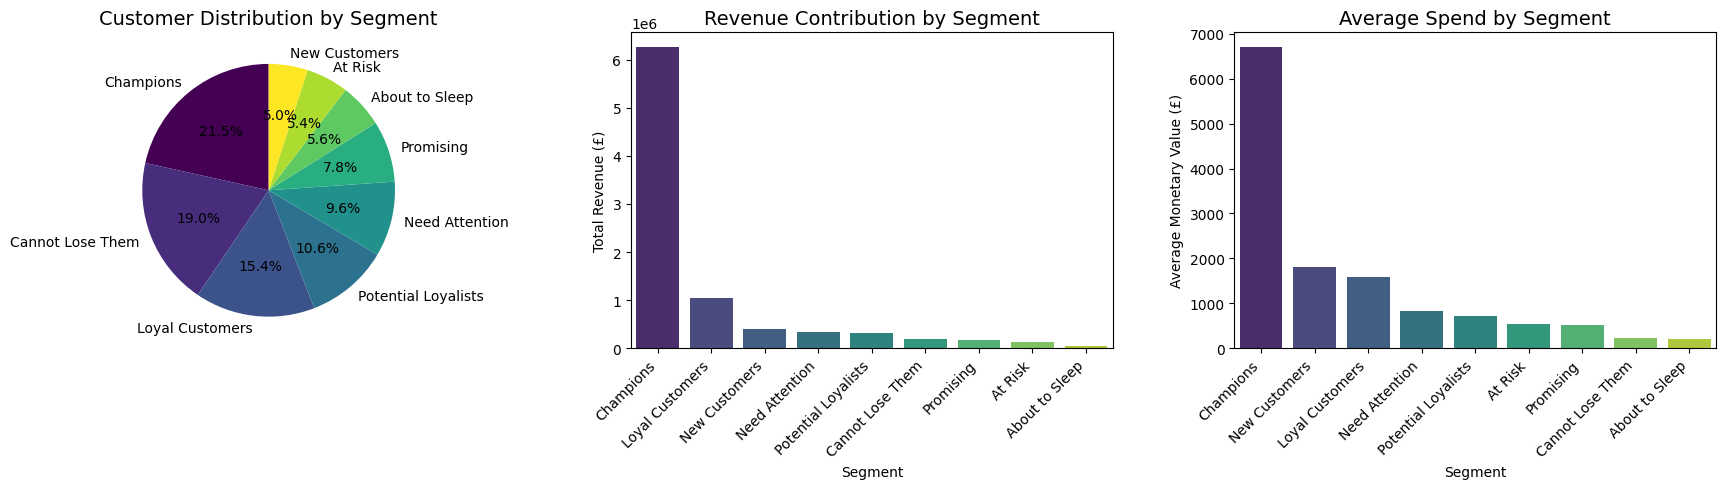

In [7]:
# --- High-Level Segment Overview ---

plt.figure(figsize=(18, 5))

# Plot 1: Customer Distribution by Segment (Pie Chart)
plt.subplot(1, 3, 1)
segment_counts = rfm_data['Segment'].value_counts()
colors = plt.cm.viridis(np.linspace(0, 1, len(segment_counts)))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Customer Distribution by Segment', fontsize=14)
plt.ylabel('') # Hide the y-label for pie charts

# Plot 2: Revenue Contribution by Segment (Bar Chart)
plt.subplot(1, 3, 2)
segment_revenue = rfm_data.groupby('Segment')['Monetary'].sum().sort_values(ascending=False)
sns.barplot(x=segment_revenue.index, y=segment_revenue.values, palette='viridis')
plt.title('Revenue Contribution by Segment', fontsize=14)
plt.xlabel('Segment')
plt.ylabel('Total Revenue (£)')
plt.xticks(rotation=45, ha='right')

# Plot 3: Average Monetary Value by Segment (Bar Chart)
plt.subplot(1, 3, 3)
avg_monetary = rfm_data.groupby('Segment')['Monetary'].mean().sort_values(ascending=False)
sns.barplot(x=avg_monetary.index, y=avg_monetary.values, palette='viridis')
plt.title('Average Spend by Segment', fontsize=14)
plt.xlabel('Segment')
plt.ylabel('Average Monetary Value (£)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

C:\Users\Dylan\AppData\Local\Temp\ipykernel_11400\1727912165.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_order_val.index, y=avg_order_val.values, palette='viridis')
C:\Users\Dylan\AppData\Local\Temp\ipykernel_11400\1727912165.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


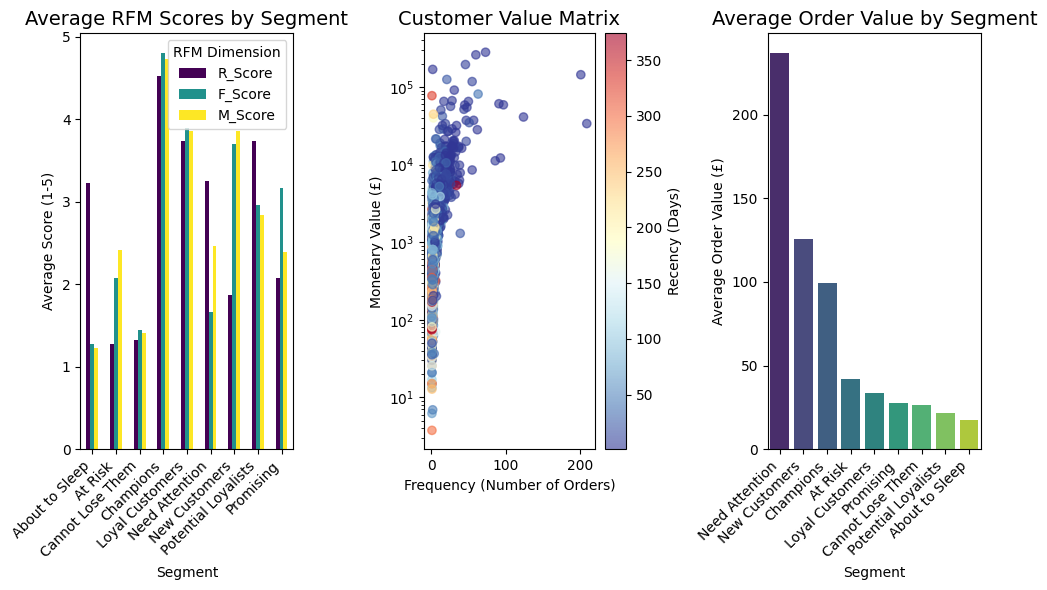

In [8]:
# --- Deeper Dive into Segment Characteristics ---

plt.figure(figsize=(18, 5))

# Plot 4: Segment Characteristics Radar-style (Bar chart version)
plt.subplot(1, 3, 1)
segment_chars = rfm_data.groupby('Segment')[['R_Score', 'F_Score', 'M_Score']].mean()
segment_chars.plot(kind='bar', figsize=(10, 6), colormap='viridis', ax=plt.gca())
plt.title('Average RFM Scores by Segment', fontsize=14)
plt.xlabel('Segment')
plt.ylabel('Average Score (1-5)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='RFM Dimension')


# Plot 5: Customer Value Matrix (Scatter Plot)
plt.subplot(1, 3, 2)
scatter = plt.scatter(rfm_data['Frequency'], rfm_data['Monetary'], c=rfm_data['Recency'], cmap='RdYlBu_r', alpha=0.6)
plt.colorbar(scatter, label='Recency (Days)')
plt.title('Customer Value Matrix', fontsize=14)
plt.xlabel('Frequency (Number of Orders)')
plt.ylabel('Monetary Value (£)')
plt.yscale('log') # Use log scale for better visibility


# Plot 6: Average Order Value by Segment
plt.subplot(1, 3, 3)
avg_order_val = rfm_data.groupby('Segment')['avg_order_value'].mean().sort_values(ascending=False)
sns.barplot(x=avg_order_val.index, y=avg_order_val.values, palette='viridis')
plt.title('Average Order Value by Segment', fontsize=14)
plt.xlabel('Segment')
plt.ylabel('Average Order Value (£)')
plt.xticks(rotation=45, ha='right')


plt.tight_layout()
# Need to use a different plt.show() command as we are using multiple plotting libraries
fig = plt.gcf() # Get the current figure
fig.show()

In [9]:
# --- Detailed Business Insights Summary ---

print("\n" + "="*50)
print("        KEY BUSINESS INSIGHTS FROM RFM ANALYSIS")
print("="*50)

# Sort segments by revenue for a logical printout
segment_summary_for_print = segment_summary.sort_values('Total_Revenue', ascending=False)

for segment in segment_summary_for_print.index:
    seg_data = segment_summary_for_print.loc[segment]
    print(f"\n- {segment.upper()} -")
    print(f"  • Customer Count: {int(seg_data['Count'])} ({seg_data['Customer_Percent']:.1f}% of total customers)")
    print(f"  • Total Revenue: £{seg_data['Total_Revenue']:,.0f} ({seg_data['Revenue_Percent']:.1f}% of total revenue)")
    print(f"  • Average Customer Value: £{seg_data['Avg_Revenue']:.0f}")
    print(f"  • Average Purchase Frequency: {seg_data['Avg_Frequency']:.1f} orders")
    print(f"  • Average Recency: {seg_data['Avg_Recency']:.0f} days since last purchase")


        KEY BUSINESS INSIGHTS FROM RFM ANALYSIS

- CHAMPIONS -
  • Customer Count: 934 (21.5% of total customers)
  • Total Revenue: £6,255,337 (70.2% of total revenue)
  • Average Customer Value: £6697
  • Average Purchase Frequency: 11.7 orders
  • Average Recency: 15 days since last purchase

- LOYAL CUSTOMERS -
  • Customer Count: 666 (15.4% of total customers)
  • Total Revenue: £1,049,296 (11.8% of total revenue)
  • Average Customer Value: £1576
  • Average Purchase Frequency: 4.3 orders
  • Average Recency: 37 days since last purchase

- NEW CUSTOMERS -
  • Customer Count: 217 (5.0% of total customers)
  • Total Revenue: £392,352 (4.4% of total revenue)
  • Average Customer Value: £1808
  • Average Purchase Frequency: 3.6 orders
  • Average Recency: 126 days since last purchase

- NEED ATTENTION -
  • Customer Count: 417 (9.6% of total customers)
  • Total Revenue: £343,729 (3.9% of total revenue)
  • Average Customer Value: £824
  • Average Purchase Frequency: 1.2 orders
  • 

---
### Summary & Next Steps

The RFM analysis has successfully segmented our customer base and revealed a critical business vulnerability: **a heavy reliance on the "Champions" segment**, which comprises just **21.5% of customers but drives a staggering 70.2% of total revenue**.

This concentration of value highlights the primary strategic imperatives for the business:
1.  **Retain "Champions":** The loss of even a small number of these customers would have a disproportionately large negative impact on revenue.
2.  **Nurture "Loyal Customers":** This segment represents the next tier of high-value customers and should be cultivated to become future Champions.
3.  **Re-engage At-Risk Segments:** Develop cost-effective strategies to reactivate dormant customers and prevent active but infrequent customers from churning.

The next phase of this project will use this segmented data as a foundation to build a predictive churn model and a quantitative business case for targeted marketing interventions.

In [10]:
# --- Save the processed data for the next notebook ---
import os

# Define the directory path for processed data
output_dir = '../data/processed'
os.makedirs(output_dir, exist_ok=True)

# Save the final RFM dataframe
rfm_data_to_save = rfm_data.reset_index() # Reset index to make CustomerID a column
file_path = os.path.join(output_dir, 'rfm_customer_data.csv')
rfm_data_to_save.to_csv(file_path, index=False)

print(f"\n[SUCCESS] Notebook 02 complete. Processed RFM data saved to: {file_path}")
print(f"Saved DataFrame has {rfm_data_to_save.shape[0]} rows and {rfm_data_to_save.shape[1]} columns.")


[SUCCESS] Notebook 02 complete. Processed RFM data saved to: ../data/processed\rfm_customer_data.csv
Saved DataFrame has 4338 rows and 13 columns.
